This script will analyze the distribution of aspect ratio of objects in a Object detection dataset where
annotations are in pascal VOC format (i.e .xml file for each images)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import csv
import xml.etree.ElementTree as ET
import fnmatch
from sklearn import preprocessing

## Convert all the annotations into CSV for analysis
Read all Annotations and store in bufffer

In [2]:
# Choose train2014 or val2014         
# This is specifically for coco dataset because file name ccontains the information that image is in train set
# or val set and we search this string in file name to load the annotations
img_set = 'train2014'

# Path where all annotations are stored
path = 'Annotations/' + '*.xml' 
files = glob.glob(path)

# empty list to store all annotations 
result = []

Now loop thorgh every file and store annotations into 2D list (#rows = #total number of objects)

And finally write all the information into a single CSV file

In [3]:
print 'Generating List............'

search_str = '*' + img_set + '*'
#Iterating through each file
for infile in files:
    if fnmatch.fnmatch(infile, search_str):
        
        tree = ET.parse(infile)
        root = tree.getroot()
        
        #Extract Name, Width and Height of Image
        width = root.find('size').find('width').text
        height = root.find('size').find('height').text
        filename = root.find('filename').text
                
        #Iterate through all GT bounding Box in Data
        
        for object in root.findall('object'):
            row = []
            #Append Image Name, Image Width and Image Height
            row.extend([filename, width, height])
            
            #Append Object name
            name = object.find('name').text
            row.append(name)
            
            #Append bounding box information
            bndbox = object.find('bndbox')
            x1 = bndbox.find('xmin').text
            y1 = bndbox.find('ymin').text
            x2 = bndbox.find('xmax').text
            y2 = bndbox.find('ymax').text
            #print 'x1: ' + x1 + ' y1: ' + y1 + ' x2: ' + x2 + ' y2: ' + y2
            row.append(x1)
            row.append(y1)
            row.append(x2)
            row.append(y2)
            
            # bbox width and height
            row.append(abs(int(x2) - int(x1)))
            row.append(abs(int(y2) - int(y1)))
           
            result.append(row)
            
print 'Generation completed'
print 'Saving the annotation into CSV for convinence'

# Saving the information in a csv file
fileName = 'log_files/' + img_set + '_ar_.csv'
with open(fileName, "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Img_Id','Img_Width','Img_Height','Object','x1','y1','x2','y2','bbox_width','bbox_height'])
    writer.writerows(result)
    
print 'Coversion Completed.'

Generating List............
Generation completed
Saving the annotation into CSV for convinence
Coversion Completed.


## load the CSV and perform analysis on data 

load the data into dataframe and drop unnecessary columns

In [4]:
# load csv into pandas dataframe
data = pd.read_csv(fileName)
drop_list = ['Img_Id', 'Img_Width', 'Img_Height', 'x1', 'x2', 'y1', 'y2']
data.drop(drop_list, inplace=True, axis=1)
print data.shape
data.head(5)

(19344, 3)


,Object,bbox_width,bbox_height
0,toilet_openToilet,413,459
1,umbrella_openUmbrella,166,49
2,umbrella_openUmbrella,157,43
3,umbrella_openUmbrella,113,37
4,umbrella_openUmbrella,73,31


Seperate bigger and smaller value from height and width and 
calculate bigger/smaller so that bounding box with similar aspect ratio 
(like 1:4 and 4:1) will be under same category. 

Then plotting the aspect ratio in logarithmic scale so that the change between two values 
is perceived on the basis of the ratio of the two values

In [5]:
# Extract the bigger side
data['bigger'] = data[['bbox_width', 'bbox_height']].max(axis=1)
# Extract the smaller side
data['smaller'] = data[['bbox_width', 'bbox_height']].min(axis=1)
# calculate the ratio bigger/smaller
data['ratio'] = data['bigger'].div(data['smaller'])
# calculate the log of ratio
data['log_ratio'] = data['ratio'].apply(np.log2)
data.head(5)

,Object,bbox_width,bbox_height,bigger,smaller,ratio,log_ratio
0,toilet_openToilet,413,459,459,413,1.111380,0.152352
1,umbrella_openUmbrella,166,49,166,49,3.387755,1.760330
2,umbrella_openUmbrella,157,43,157,43,3.651163,1.868356
3,umbrella_openUmbrella,113,37,113,37,3.054054,1.610726
4,umbrella_openUmbrella,73,31,73,31,2.354839,1.235628


In [35]:
data['log_ratio'].describe()

count    19344.000000
mean         0.806603
std          0.614783
min          0.000000
25%          0.317046
50%          0.671214
75%          1.184425
max          4.251375
Name: log_ratio, dtype: float64

Binning the log of ratio into 5 equal bins and calculating the frequency of instances
in each bin

In [6]:
# min to max at distance of 1
bins = [0, 1, 2, 3, 4, 5]
bin_labels = [ '1' , '2', '3', '4', '5']
print bins
data['bin_log_ratio'] = pd.cut(data['log_ratio'], bins, labels=bin_labels)
# General trend of aspect ration in complete dataset
ar_count = pd.value_counts(data['bin_log_ratio']).tolist()
ar_count = [int(i) for i in ar_count]
print ar_count

[0, 1, 2, 3, 4, 5]
[12997, 5382, 734, 74, 5]


Plotting the stats of complete dataset

In [7]:
# Plot size to 14" x 7"
matplotlib.rc('figure', figsize = (14, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

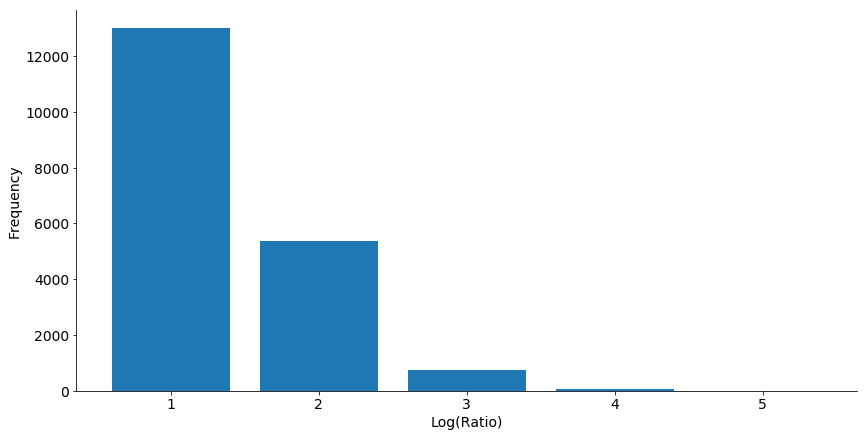

In [8]:
X = range(1,len(bin_labels)+1)
#print X
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["bottom"].set_visible(True)    
ax.spines["left"].set_visible(True) 

#freq= pd.value_counts(data['bin_log_ratio'])
plt.ylabel('Frequency')
plt.xlabel('Log(Ratio)')

plt.bar(X,ar_count)
plt.xticks(X, bin_labels)
plt.show()

Grouping data accoding to object categories and calculating the percent of instances in each 
aspect ratio binned categories

In [9]:
# Group Data accoding to the object categories
grouped_data = data.groupby(['Object'])
freq = {}
# calculate the proportion of instances in each bin in each group
for name,group in grouped_data:
     freq[name] = pd.value_counts(group['bin_log_ratio'], normalize=True).tolist()
df = pd.DataFrame(freq, index=X)
# Convert the proportion into %
df.loc[:,:] *= 100
df.head()

,laptop_closedLaptop,laptop_openLaptop,scissors_closedScissor,scissors_openScissor,suitcase_closedSuitcase,suitcase_openSuitcase,toilet_closedToilet,toilet_openToilet,umbrella_closedUmbrella,umbrella_openUmbrella
1,44.923858,90.951743,58.457375,71.794872,75.761487,86.531987,82.309400,81.922817,46.739130,53.258427
2,42.639594,8.411528,35.994587,24.358974,22.922044,13.131313,15.470022,16.858497,25.931677,41.221910
3,11.928934,0.603217,5.412720,3.205128,1.264843,0.336700,1.850481,1.218687,22.360248,5.042135
4,0.507614,0.033512,0.135318,0.641026,0.051626,0.000000,0.370096,0.000000,4.968944,0.407303
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070225


Plot the propotion of instances in each group according to their aspect ratio which is binned into 5 categories

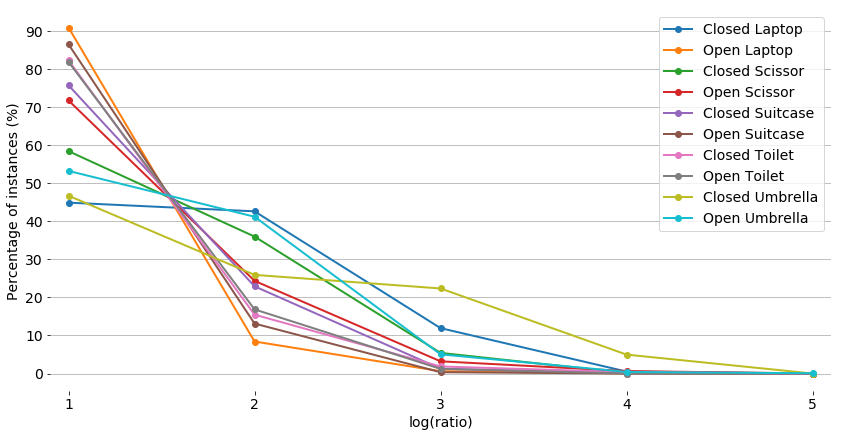

In [10]:
# for setting ticks along y axis
Y = range(0,100, 10)
# Labels for legend
legend_label = ['Closed Laptop', 'Open Laptop', 'Closed Scissor', 'Open Scissor',
               'Closed Suitcase', 'Open Suitcase', 'Closed Toilet', 'Open Toilet',
               'Closed Umbrella', 'Open Umbrella']
df.plot(linewidth=2.0, marker='o')
plt.ylabel('Percentage of instances (%)')
plt.xlabel('log(ratio)')
plt.xticks(X, bin_labels)
plt.yticks(Y)
ax = plt.axes()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# horizontal grids
ax.yaxis.grid(True)
# Adding small margin on left and right
ax.set_xlim(ax.get_xlim()[0] - 0.1, ax.get_xlim()[1] + 0.1)
# Adding Legend
ax.legend(legend_label)
plt.show()
#plt.savefig('log_files/val_bbox_ar.png', transparent=True, bbox_inches='tight')